**Predicting Global Supply Chain**

Key Question: Can we use procurement transaction data to predict whether a delivery is delayed and estimating the length of the delay and price discovery

**Notebook 1: Data Cleaning & Feature Engineering**

**Part 1 Data Cleaning**

In [287]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import missingno as msno
import openpyxl
import helper12 as scmhelper
%matplotlib inline

Load the data files

In [288]:
# Data Source: https://data.pepfar.net/additionalData, downloaded as excel file
full = pd.ExcelFile('data/src/SCMS Data 20151023.xlsx')
print("Sheetnames: ",full.sheet_names)
parsed_data = scmhelper.parse_raw_data(full)
all_sheets_df = pd.read_excel(full, sheet_name=full.sheet_names[3])
print(all_sheets_df.shape )
#print(data.head(5))
for df in parsed_data:
    print(df.name," shape:",df.shape )

# View ref top rows
summary, purpose, ref, data = parsed_data
data.head(5)

Sheetnames:  ['Summary ', 'Data Purpose and Notes', 'Data Dictionary', 'SCMS Delivery History Dataset']
(10324, 33)
summary  shape: (0, 0)
purpose  shape: (0, 0)
ref  shape: (33, 5)
data  shape: (10324, 33)


,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


Check Duplicates

In [289]:
data.duplicated().sum()

0

Rename Columns

In [290]:
newcol_list = ['id', 'proj_code', 'pq_no', 'po_no', 'ship_no', 'country'
     , 'mngr', 'fulfill_via','vendor_terms', 'ship_mode', 'pq_date'
     , 'po_date', 'del_date_scheduled' ,'del_date_client', 'del_date_recorded'
     , 'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand'
     , 'dosage','dosage_form', 'units', 'ln_itm_qty', 'ln_itm_val', 'pk_price'
     , 'unit_price', 'factory', 'first_line', 'weight', 'freight_cost', 'line_itm_ins']
data = scmhelper.rename_data_columns(data, newcol_list)

Old columns:  Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')
New columns:  Index(['id', 'proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'del_date_scheduled', 'del_date_client', 'del_date_recorded',
       'prod_grp', 'sub_class', 'vendor', 'itm_

Update references

In [291]:
# Add these new columns to reference and make a lookup function in case we forget what it means
ref['NewColumn']= data.columns 
#ref.to_excel("Reference.xlsx") # save to disk
# Example usage of the reference function below:
scmhelper.getReferenceInfo(data, data.columns[5], ref)

5    Country
Name: FieldName, dtype: object 
, 5    Text
Name: DataType, dtype: object 
, 5    Destination country
Name: FieldDescription, dtype: object 
, 5    NaN
Name: FieldNotes, dtype: object 
          Examples: 
0    Côte d'Ivoire
1          Vietnam
2    Côte d'Ivoire
3          Vietnam
4          Vietnam
Name: country, dtype: object 



Converts data types

In [292]:
# First use helper function to get column report and blocks of data by column type
data_types = data.dtypes
unique_items = list(set(data_types))
print(unique_items[2])   
blocks = scmhelper.blocks_by_dtype(data)

object
Total Number of Columns: 33
Breakdown....

Type: int64 , Count: 3 
Columns and null counts---: 
id            0
units         0
ln_itm_qty    0
dtype: int64

Type: object , Count: 23 
Columns and null counts---: 
proj_code           0
pq_no               0
po_no               0
ship_no             0
country             0
mngr                0
fulfill_via         0
vendor_terms        0
ship_mode         360
pq_date             0
po_date             0
prod_grp            0
sub_class           0
vendor              0
itm_desc            0
molecule_test       0
brand               0
dosage           1736
dosage_form         0
factory             0
first_line          0
weight              0
freight_cost        0
dtype: int64

Type: datetime64[ns] , Count: 3 
Columns and null counts---: 
del_date_scheduled    0
del_date_client       0
del_date_recorded     0
dtype: int64

Type: float64 , Count: 4 
Columns and null counts---: 
ln_itm_val        0
pk_price          0
unit_price       

In [293]:
blocks.keys()


dict_keys([dtype('int64'), dtype('O'), dtype('<M8[ns]'), dtype('float64')])

dict_keys(['float64', 'int64', 'datetime64[ns]', 'object'])

In [294]:
dint,dobject, ddate, dfloat  = [d for d in blocks.values()]
print(dfloat.shape, dint.shape, ddate.shape, dobject.shape)

(10324, 4) (10324, 3) (10324, 3) (10324, 23)


### Verify Missing Values



<Axes: >

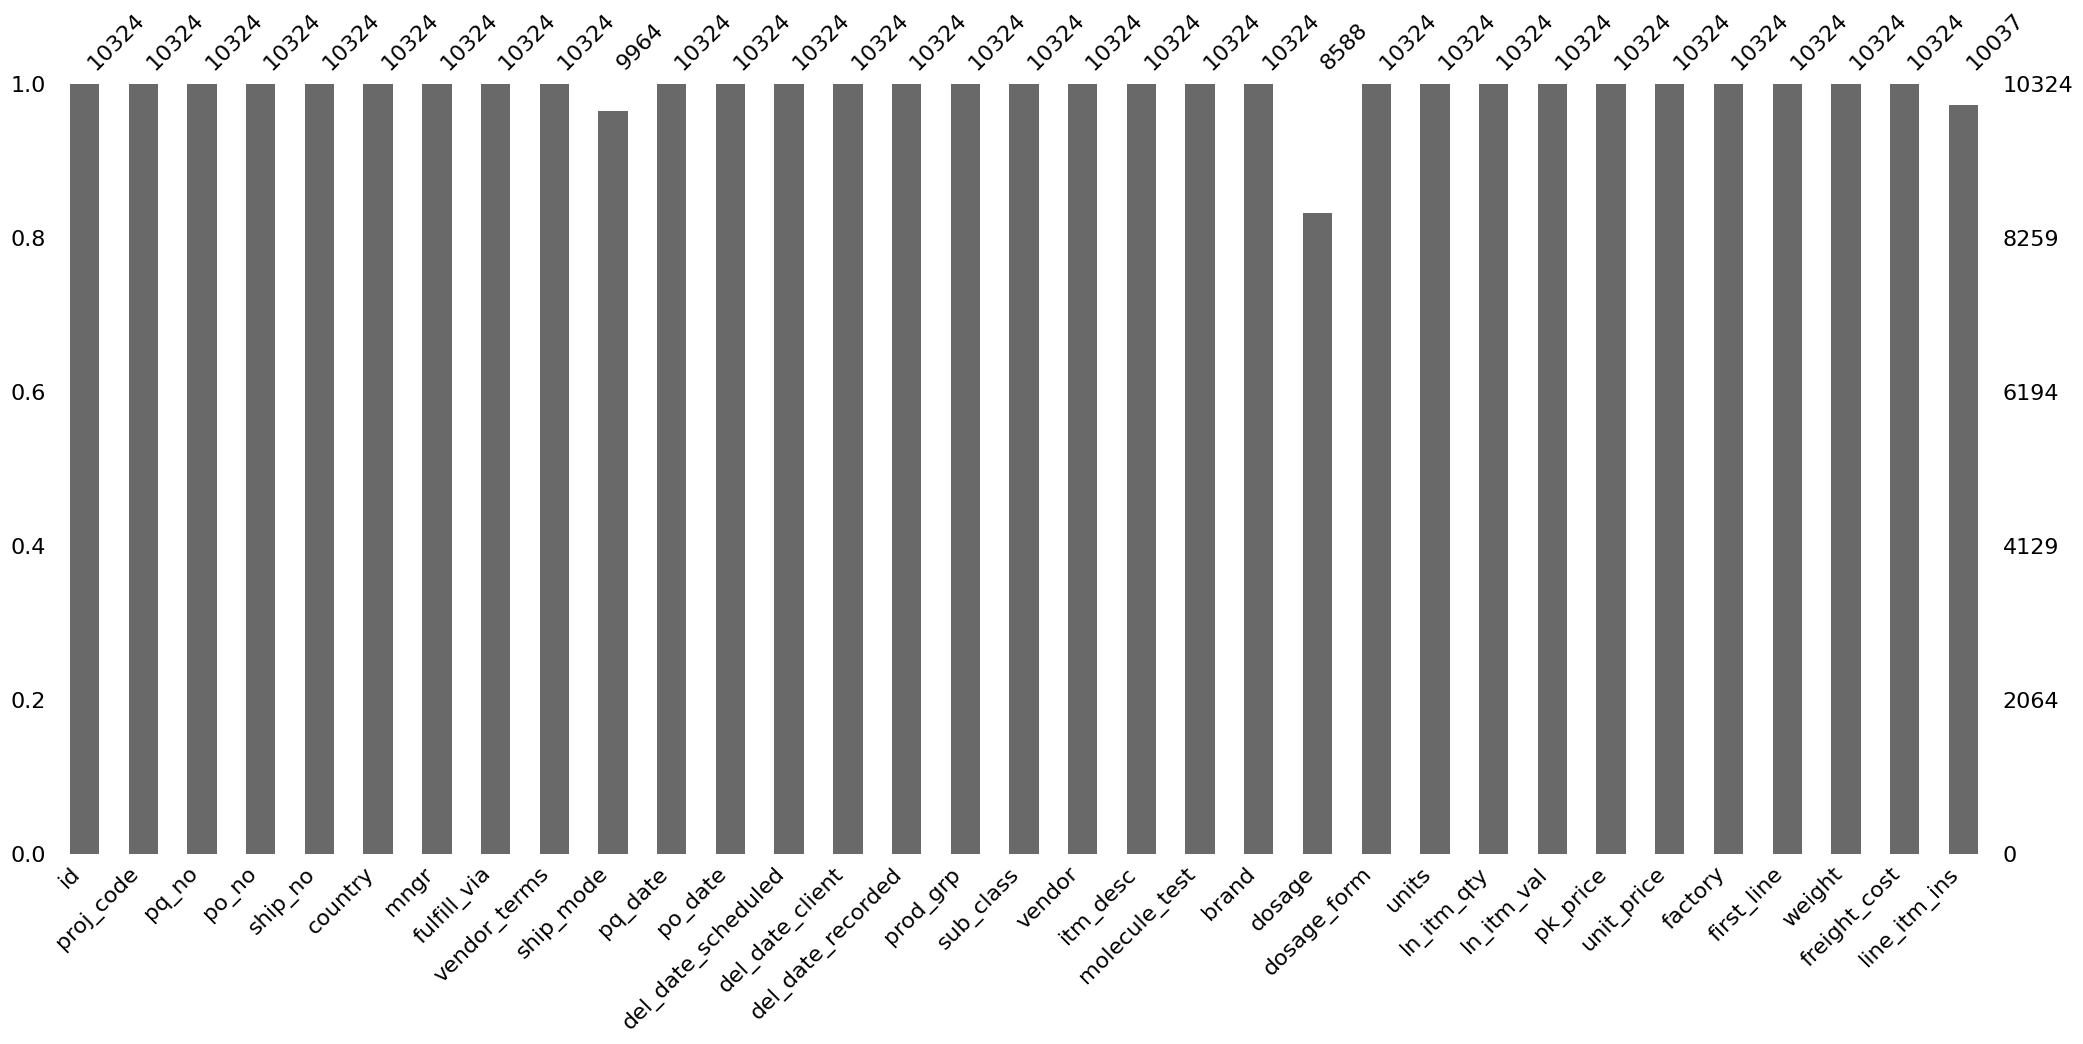

In [295]:
msno.bar(data, labels=True)

<Axes: >

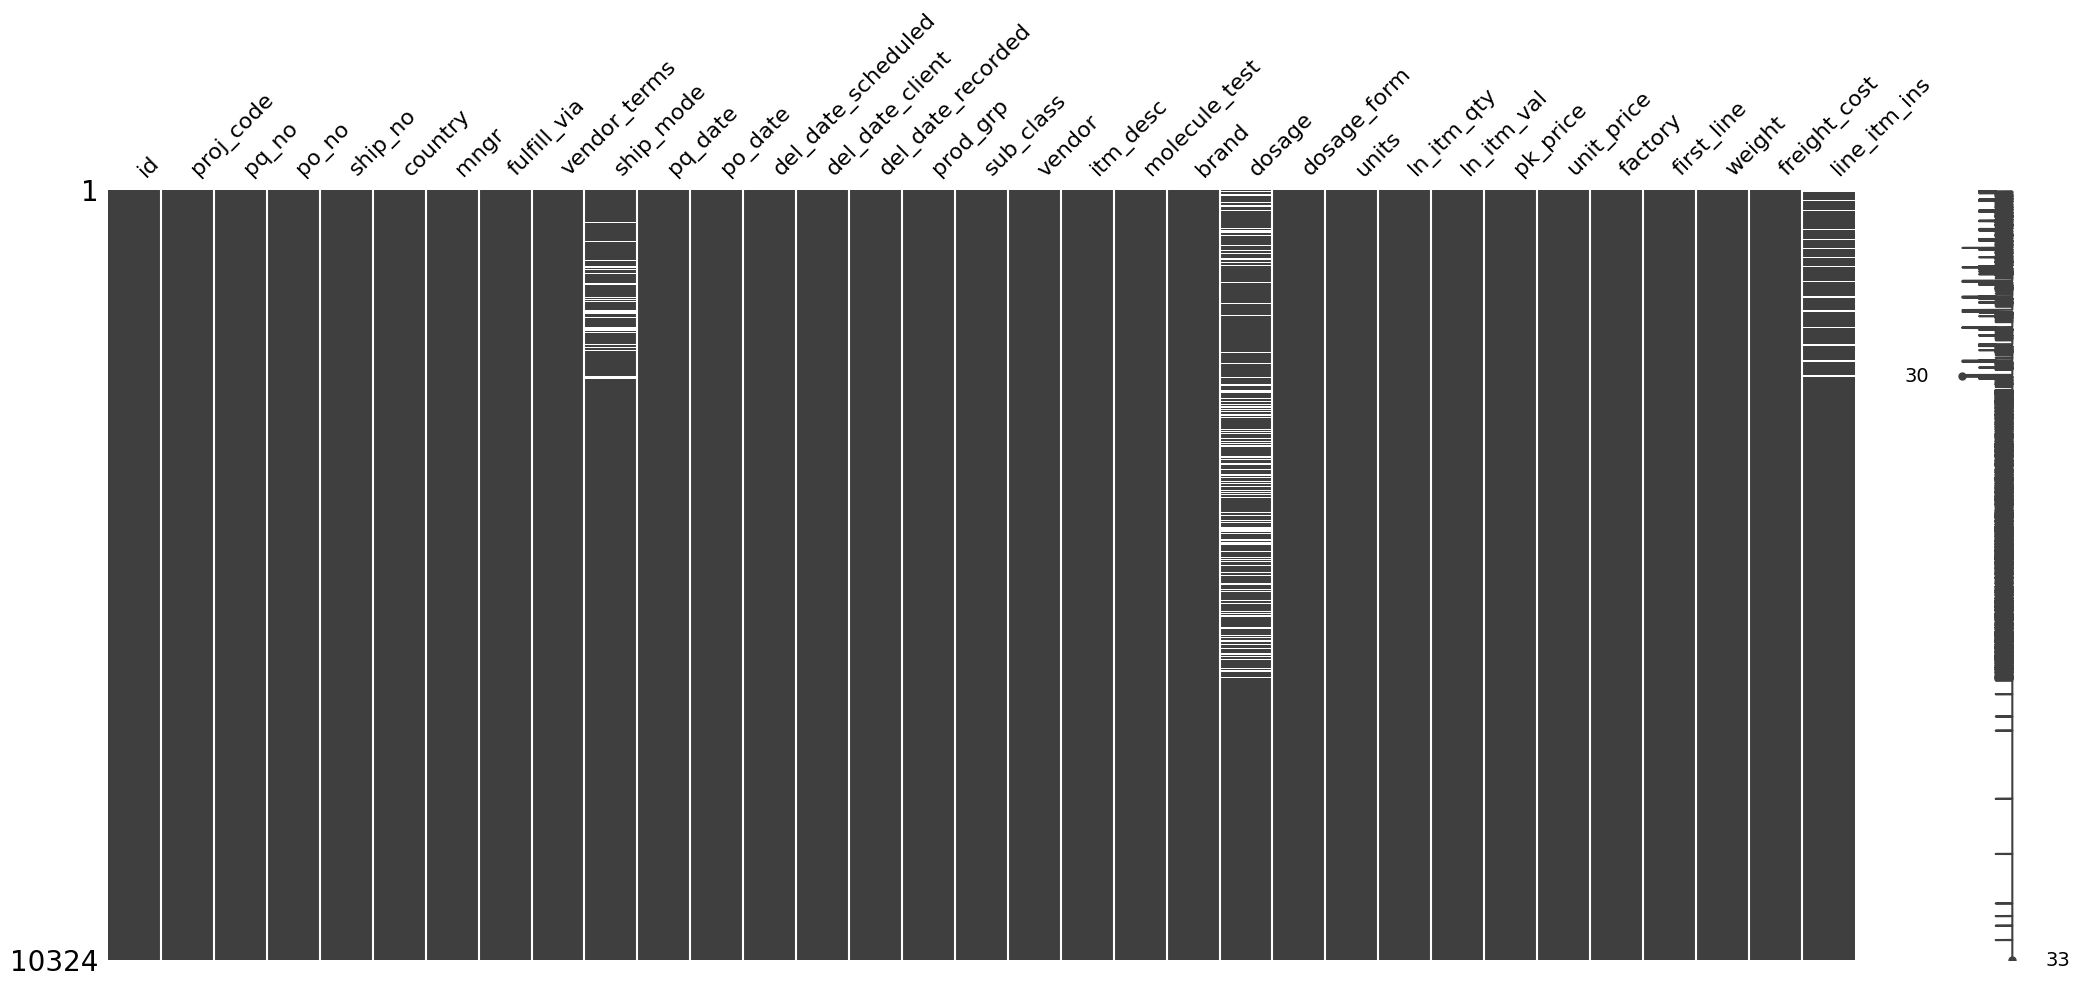

In [296]:
msno.matrix(data)

#### Missing values
From above, we can see that:

    -Dosage has a significant number of missing values
    - Line item Insurance and shipping mode have similarly moderate levels of missing values

*Fix Dosage Missing values*

In [297]:
#### Fix the missing values for the dosage feature
# Dosage has a lot of missing values
print(dobject.keys())
dosage_nulls = dobject[dobject.dosage.isnull()]
# dosage_nulls.to_excel("Dosage_Nulls.xlsx")
# Excel investigation: Corelated with country, item_desc (Mostly HIV rapid test kits), molecule test
#, vendor_terms (EXnW??), fulfill_via (by air), Brand, dosage_form, units?# pk_price, factory
dosage_lkup = dobject[[ 'itm_desc', 'molecule_test', 'brand', 'dosage_form', 'dosage' ]].groupby(
[ 'itm_desc', 'molecule_test', 'brand','dosage_form']).max()
# Realize they are all test kits, 
dosage_lkup[dosage_lkup.dosage.isnull()].reset_index().dosage_form.value_counts()

Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost'],
      dtype='object')


dosage_form
Test kit                37
Test kit - Ancillary     9
Name: count, dtype: int64

In [298]:
def data_fill_na(data, column, fillvalue):
    print("Before: \n:", data.isnull().sum()[data.isnull().sum()>0])
    # So use NA-TestKit/Ancillary as dosage value
    data[column].fillna(value=fillvalue, inplace=True)
    # Check the nulls once again, these should be mainly from the date columns
    print("---\nAfter: \n:", data.isnull().sum()[data.isnull().sum()>0])
    return data    

In [299]:
dobject = data_fill_na(dobject, 'dosage', 'TestKit/Ancillary')

Before: 
: ship_mode     360
dosage       1736
dtype: int64
---
After: 
: ship_mode    360
dtype: int64


In [300]:
#### Fix the missing values for the dosage feature
# Dosage has a lot of missing values
def describe_nulls(data, column):
    nulls = data[data[column].isnull()]
    #nulls.to_excel(column+"_nulls.xlsx")
    for col in nulls:
        #print('\n',col,"nulls summary: \nCount: {} \nUnique: {} \nTop Freq: {}".format(col.count()
        #      ,len(col.unique()), col.values_count()[:3]))
        print('\n-------\n',nulls[col].describe())

In [301]:
describe_nulls(dobject, 'ship_mode')


-------
 count            360
unique            15
top       110-ZM-T01
freq              99
Name: proj_code, dtype: object

-------
 count                360
unique                 1
top       Pre-PQ Process
freq                 360
Name: pq_no, dtype: object

-------
 count            360
unique           220
top       SCMS-16600
freq              18
Name: po_no, dtype: object

-------
 count          360
unique         226
top       ASN-1520
freq            16
Name: ship_no, dtype: object

-------
 count               360
unique               12
top       Côte d'Ivoire
freq                113
Name: country, dtype: object

-------
 count          360
unique           1
top       PMO - US
freq           360
Name: mngr, dtype: object

-------
 count          360
unique           2
top       From RDC
freq           312
Name: fulfill_via, dtype: object

-------
 count                360
unique                 5
top       N/A - From RDC
freq                 312
Name: vendor_terms, dtype:

In [302]:
data, column, groupby = [dobject.copy(), 'ship_mode',['country', 'itm_desc', 'ship_mode']]
# make cx
cx=data.groupby(groupby).agg('count').reset_index()[['country', 'itm_desc', 'ship_mode']]
print(cx.shape, cx.columns)
cx = cx.groupby(['country', 'itm_desc']).min().reset_index()
# make cy
cy = pd.merge(data, cx, how='left', left_on=['country', 'itm_desc']
         , right_on=['country', 'itm_desc'], suffixes=('','_y'))
print(cy.shape, cy.columns)
# assign
cy['ship_mode'] = cy.ship_mode.where(cy.ship_mode.notnull(), cy.ship_mode_y)
still_null= cy.ship_mode.isnull().index # find remiaining nulls
a = data.ship_mode.value_counts()/data.ship_mode.value_counts().sum() # values distributed randomness 
for j in still_null:
    cy.loc[j,'ship_mode'] = np.random.choice([i for i in a.index], p=[v for v in a])
cy.ship_mode.isnull().sum()
# Drop
cy.drop('ship_mode_y', axis=1, inplace=True)
print(cy.shape)
dobject= cy.copy()

(1323, 3) Index(['country', 'itm_desc', 'ship_mode'], dtype='object')
(10324, 24) Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 'ship_mode_y'],
      dtype='object')
(10324, 23)


Insurance

In [303]:
dfloat.isnull().sum()

ln_itm_val        0
pk_price          0
unit_price        0
line_itm_ins    287
dtype: int64

In [304]:
yr = pd.Series([str(x).split("-")[0] for x in ddate.del_date_scheduled], index = ddate.del_date_scheduled.index)
d_ins = dobject[dfloat.line_itm_ins.isnull()]
#d_ins.to_excel('line_insurance_missing_values.xlsx')
# Most missing values driven by 2007 items, so use lower end of 2007 insurance
# Use Median Value
q1 = np.percentile(dfloat[yr == '2007'].dropna()['line_itm_ins'], 0.5)
dfloat.fillna(value=q1, inplace=True)
q1

0.0024500000000000012

### Misclassified/Misplaced Features
#### e.g. dates cast as objects etc.

In [305]:
# Check po columns 
dobject[['pq_date', 'po_date']].describe()

,pq_date,po_date
count,10324,10324
unique,765,897
top,Pre-PQ Process,N/A - From RDC
freq,2476,5404


In [306]:
dobject.info() # Notice pq_date and po_date should be datetime type but currently classified as object columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   proj_code      10324 non-null  object
 1   pq_no          10324 non-null  object
 2   po_no          10324 non-null  object
 3   ship_no        10324 non-null  object
 4   country        10324 non-null  object
 5   mngr           10324 non-null  object
 6   fulfill_via    10324 non-null  object
 7   vendor_terms   10324 non-null  object
 8   ship_mode      10324 non-null  object
 9   pq_date        10324 non-null  object
 10  po_date        10324 non-null  object
 11  prod_grp       10324 non-null  object
 12  sub_class      10324 non-null  object
 13  vendor         10324 non-null  object
 14  itm_desc       10324 non-null  object
 15  molecule_test  10324 non-null  object
 16  brand          10324 non-null  object
 17  dosage         10324 non-null  object
 18  dosage_form    10324 non-n

In [307]:
# We see that pq_date and po_date have some non-date values
for c  in ['po_date', 'pq_date']:
    print("-----\nNon-datetime entries for {}: {}".format(c,
        [x for x in dobject[c].unique() if type(x) == str]))

-----
Non-datetime entries for po_date: ['Date Not Captured', 'N/A - From RDC']
-----
Non-datetime entries for pq_date: ['Pre-PQ Process', 'Date Not Captured']


Text(0.5, 1.0, '20 Most-Frequent Categories in PO_Date')

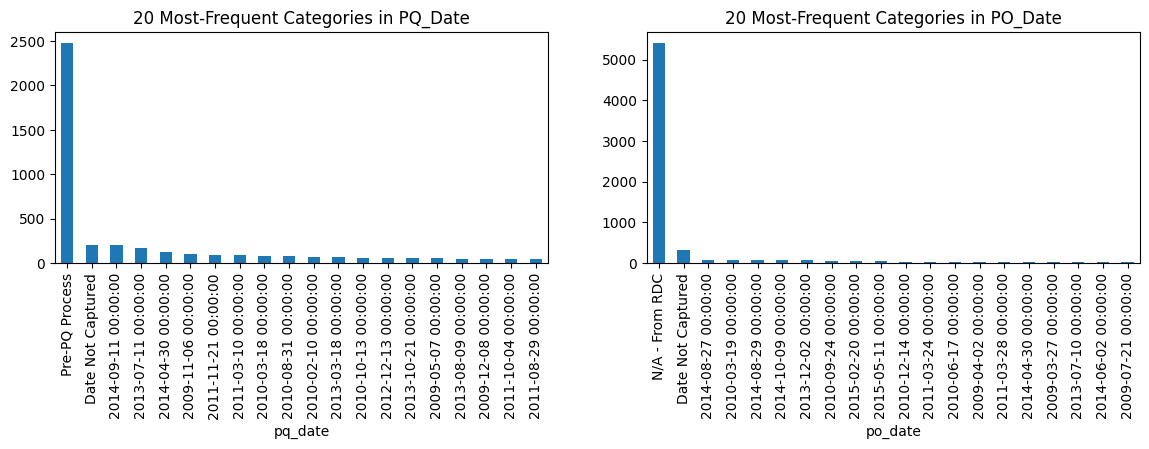

In [308]:
# Investigate the size of these string descriptions, we see they are quite significant. 
# Date not Captured is noticeable but not a lot, more investigation...
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))
data['pq_date'].value_counts()[:20].plot(kind='bar', ax=ax1)
ax1.set_title("20 Most-Frequent Categories in PQ_Date")
data['po_date'].value_counts()[:20].plot(kind='bar', ax=ax2)
ax2.set_title("20 Most-Frequent Categories in PO_Date")

In [309]:
# Let's take this outside..to excel
po_idx = dobject[(dobject.po_date=='Date Not Captured')|(dobject.po_date=="N/A - From RDC")].index        
pq_idx = dobject[(dobject.pq_date=='Pre-PQ Process') | (dobject.pq_date=='Date Not Captured')].index
dnc_idx = list(po_idx) + list(pq_idx)

#dobject.loc[dnc_idx,:].to_excel("po_pq_date_not_captured.xlsx")
#ddate.loc[dnc_idx,:].to_excel('po_pq_date_not_captured_comp.xlsx')

# For South Africa, We find 2 project codes that are responsible..and a few countries too
dobject[(dobject.proj_code=='116-ZA-T30')
| (dobject.proj_code =='116-ZA-T01')].to_excel('po_pq_date_not_captured_ref.xlsx')

dnc_proj_idx = list(dobject[(dobject.proj_code=='116-ZA-T30')
| (dobject.proj_code =='116-ZA-T01')].index)
ddate.loc[dnc_proj_idx,:].to_excel('po_pq_date_not_captured_comp_proj.xlsx')

In [310]:
print(len(po_idx), len(pq_idx), len(dnc_idx))

5732 2681 8413


In [311]:
data, column, groupby = [dobject.copy(), 'po_date',['country', 'Itm_desc','del_date_scheduled','po_date']]
#ddate.del_date_scheduled[dnc_idx] - pd.to_datetime(dobject.po_date[dnc_idx])
dx = pd.merge(dobject, ddate, how='left', left_index=True, right_index=True)
dx.po_date.replace({'Date Not Captured':pd.to_datetime('1900')
                    , 'N/A - From RDC':pd.to_datetime('1910')}, inplace=True)
dx.pq_date.replace({'Date Not Captured':pd.to_datetime('1970')
                    , 'Pre-PQ Process':pd.to_datetime('1980'),}, inplace=True)
dx['po_date_est'] = dx.del_date_scheduled - pd.to_datetime(dx.po_date)
dx['pq_date_est'] = pd.to_datetime(dx.po_date) - pd.to_datetime(dx.pq_date)

#### Replace strings with dummy dates, estimate days from purchase order to scheduled delivery

In [312]:
## Make Sandbox...
dd , do = ddate.copy(),dobject.copy()
do.po_date.replace({'Date Not Captured':pd.to_datetime('1900')
                    , 'N/A - From RDC':pd.to_datetime('1910')}, inplace=True)
do.pq_date.replace({'Date Not Captured':pd.to_datetime('1970')
                    , 'Pre-PQ Process':pd.to_datetime('1980'),}, inplace=True)
print(dd.shape, do.shape)
for col in ['pq_date', 'po_date']:
    dd[col] = pd.to_datetime(do[col])
    do.drop(col, axis=1, inplace=True)
print(dd.shape, do.shape)
dd.head()
# do conversions...
estdates =['pq_date','po_date'] 
time_factor = 1e9*3600*24.0
for c in estdates:
    dd[c+"_est"] = pd.to_numeric(dd['del_date_scheduled'] - dd[c])/(time_factor)
print("\n Describe..",dd.describe())

(10324, 3) (10324, 23)
(10324, 5) (10324, 21)

 Describe..                   del_date_scheduled                del_date_client  \
count                          10324                          10324   
mean   2011-10-04 15:30:28.593568512  2011-09-28 14:56:34.963192576   
min              2006-05-02 00:00:00            2006-05-02 00:00:00   
25%              2009-09-08 00:00:00            2009-09-01 00:00:00   
50%              2011-12-05 00:00:00            2011-11-25 00:00:00   
75%              2013-12-23 00:00:00            2013-12-23 00:00:00   
max              2015-12-31 00:00:00            2015-09-14 00:00:00   
std                              NaN                            NaN   

                   del_date_recorded                        pq_date  \
count                          10324                          10324   
mean   2011-10-01 12:33:28.523827968  2003-10-20 01:41:24.153428864   
min              2006-05-02 00:00:00            1970-01-01 00:00:00   
25%              

In [313]:
# Make seperate indices
fillvals = ['1900', '1910', '1970', '1980']
po_dnc_i, po_rdc_i  = list(dd[dd.po_date==fillvals[0]].index), list(dd[dd.po_date==fillvals[1]].index)
pq_dnc_i,pq_pqp_i = list(dd[dd.pq_date==fillvals[2]].index),list(dd[dd.pq_date==fillvals[3]].index)
print("Length PO troublesome indices: ",len(set(po_dnc_i+po_rdc_i)))
print("Length PQ troublesome indices: ",len(set(pq_dnc_i+pq_pqp_i)))
# Merge with country vendor then add year variable
dd = pd.merge(dd, do[['country', 'vendor', 'itm_desc']], how="left", right_index=True, left_index=True)
dd['year'] = [x.year for x in dd.del_date_scheduled]
print(dd.columns)

Length PO troublesome indices:  5732
Length PQ troublesome indices:  2681
Index(['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'pq_date_est', 'po_date_est', 'country', 'vendor',
       'itm_desc', 'year'],
      dtype='object')


#### Make Purchase order date (po_date)  lookup dataframe and merge

In [314]:
# Make lookup tables with alternate FillValues (summary stats) 
print("\nBegin mean: ", dd.mean(numeric_only=True))
# drop the problem items first  in the right order then aggregate at right level
dd_trim= dd.drop(po_dnc_i + po_rdc_i, axis=0)
print("\nEnd mean: ",dd_trim.mean(numeric_only=True))
# Make lookup tables for po
print("dd_trim", dd_trim.head())
po_lkup = dd_trim.groupby(['country', 'year']).agg('mean',numeric_only=True).reset_index()
po_lkup_yr = dd_trim.groupby(['year']).agg('mean',numeric_only=True).reset_index()
print("\Lookup table columns: ",po_lkup.columns,po_lkup_yr.columns)
# Now merge with original dd, not dd_trim..
#del tst;del tst2
# Merge with more detailed averages, country-year level
print(dd.loc[po_rdc_i + po_dnc_i,'po_date'].value_counts()[:10])
tst =pd.merge(dd, po_lkup, left_on=['country','year'],
        right_on=['country', 'year'], how='left')
print("\nNulls remaining: ",tst['po_date_est_y'].isnull().sum())
# # Merge with less detailed averages, year level
tst2 =pd.merge(tst, po_lkup_yr, left_on=['year'],
        right_on=['year'], how='left')
print("\nNulls remaining: ",tst2['po_date_est'].isnull().sum())
print(tst2[['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'pq_date_est_x','po_date_est_x','pq_date_est_y','po_date_est_y',
            'pq_date_est','po_date_est']].head())
dd = tst2[['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'pq_date_est_x','po_date_est_x','pq_date_est_y','po_date_est_y',
            'pq_date_est','po_date_est']]


Begin mean:  pq_date_est     2906.575746
po_date_est    20701.253003
year            2011.257555
dtype: float64

End mean:  pq_date_est    1851.457753
po_date_est     105.742596
year           2011.851699
dtype: float64
dd_trim    del_date_scheduled del_date_client del_date_recorded    pq_date    po_date  \
9          2007-01-30      2007-01-30        2007-01-30 1980-01-01 2006-11-13   
10         2007-02-16      2007-02-16        2007-02-16 1980-01-01 2006-12-01   
13         2007-02-27      2007-02-27        2007-02-27 1980-01-01 2006-12-22   
15         2007-03-19      2007-03-19        2007-03-19 1980-01-01 2007-01-10   
18         2007-06-06      2007-06-06        2007-06-06 1980-01-01 2007-04-12   

    pq_date_est  po_date_est   country  \
9        9891.0         78.0    Zambia   
10       9908.0         77.0    Zambia   
13       9919.0         67.0    Rwanda   
15       9939.0         68.0  Zimbabwe   
18      10018.0         55.0  Tanzania   

                               

#### PO Dates -  Estimates 

In [315]:
###### Estimate PO DATE using fill values and conditional logic on df ##########
# Merge the columns into one first and second
dd['po_datediff'] = dd.po_date_est_x
print("---\nTotal  obs: {}, \nFrom _X: {}, \nFrom _Y: {}, Still Null: {}".format(
    len(dd.po_datediff), sum(dd.po_datediff==dd.po_date_est_x)
      , sum(dd.po_datediff==dd.po_date_est_y), dd.po_datediff.isnull().sum()))
m1 = dd.po_datediff < 2000
dd['po_datediff'].where(m1,dd.po_date_est_y,inplace=True)
print("---\nTotal  obs: {}, \nFrom _X: {}, \nFrom _Y: {}, Still Null: {}".format(
    len(dd.po_datediff), sum(dd.po_datediff==dd.po_date_est_x)
      , sum(dd.po_datediff==dd.po_date_est_y), dd.po_datediff.isnull().sum()))
# DEal with the remaining nulls
print('Mean for PO DaTE: ',dd.po_datediff.mean(numeric_only=True))
m2 = dd.po_datediff.notnull()
dd['po_datediff'].where(m2,dd.po_date_est,inplace=True)
print("---\nTotal  obs: {}, \nFrom _Y: {}, Still Null: {}".format(
    len(dd.po_datediff), sum(dd.po_datediff==dd.po_date_est), dd.po_datediff.isnull().sum()))
print('Mean for PO DaTE: ',dd.po_datediff.mean(numeric_only=True))
## Calculating New PO Date, Finally!
days = [pd.Timedelta(str(x)+" days") for x in dd.po_datediff]
#data = [pd.Timedelta(str(x)+" days") for x in dd.po_datediff]
date_arr = []
print("data",len(days))
print(len(dd.del_date_scheduled))
for i in range(len(days)):
    date_arr.append(dd.del_date_scheduled[i]-days[i])

dd['po_date_new'] =  date_arr#dd.del_date_scheduled-[pd.Timedelta(str(x)+" days") for x in dd.po_datediff]
print(dd.po_date_new.isnull().sum())

---
Total  obs: 10324, 
From _X: 10324, 
From _Y: 23, Still Null: 0
---
Total  obs: 10324, 
From _X: 4592, 
From _Y: 5602, Still Null: 153
Mean for PO DaTE:  104.24235249154218
---
Total  obs: 10324, 
From _Y: 153, Still Null: 0
Mean for PO DaTE:  103.7977957331665
data 10324
10324
0


#### Purchase Quote Dates - New Estimates 

In [316]:
###### PQ DATE is then derived from NEW PO DATE ########
# keep it simple i.e. what is the average podate pqdate diff without the problem areas?
dd['pq_datediff'] = dd.pq_date_est_x
pq_mean = dd.drop(pq_dnc_i+pq_pqp_i, axis=0)['pq_datediff'].mean(numeric_only=True)
print(dd.pq_date_est_x.mean(numeric_only=True))
print(pq_mean)
n1 = dd.pq_datediff < 2000
dd['pq_datediff'] = dd['pq_datediff'].where(n1,pq_mean)
record_nums = len(dd.po_date_new)
delta_arr = [pd.Timedelta(str(x)+" days") for x in dd.pq_datediff]
date_arr = []
for i in range(record_nums):
    date_arr.append(dd.po_date_new[i]-delta_arr[i])
dd['pq_date_new'] =date_arr #dd.po_date_new -[pd.Timedelta(str(x)+" days") for x in dd.pq_datediff]
print(dd.mean(numeric_only=True))
ddate = dd[['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date','po_date_new', 'pq_date_new']]
ddate.columns

2906.5757458349476
172.24349077587334
pq_date_est_x     2906.575746
po_date_est_x    20701.253003
pq_date_est_y     2582.371079
po_date_est_y      104.242352
pq_date_est       2659.086700
po_date_est        102.549427
po_datediff        103.797796
pq_datediff        172.243491
dtype: float64


Index(['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'po_date_new', 'pq_date_new'],
      dtype='object')

#### Weight and Freight Cost
#### The freight cost and weight columns should be either floats or ints 
#### But currently are misclassified as "object"

        proj_code           pq_no     po_no  ship_no        country      mngr  \
0      100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire  PMO - US   
1      108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam  PMO - US   
2      100-CI-T01  Pre-PQ Process   SCMS-20   ASN-14  Côte d'Ivoire  PMO - US   
3      108-VN-T01  Pre-PQ Process   SCMS-78   ASN-50        Vietnam  PMO - US   
4      108-VN-T01  Pre-PQ Process   SCMS-81   ASN-55        Vietnam  PMO - US   
...           ...             ...       ...      ...            ...       ...   
10319  103-ZW-T30       FPQ-15197  SO-50020  DN-4307       Zimbabwe  PMO - US   
10320  104-CI-T30       FPQ-15259  SO-50102  DN-4313  Côte d'Ivoire  PMO - US   
10321  110-ZM-T30       FPQ-14784  SO-49600  DN-4316         Zambia  PMO - US   
10322  200-ZW-T30       FPQ-16523  SO-51680  DN-4334       Zimbabwe  PMO - US   
10323  103-ZW-T30       FPQ-15197  SO-50022  DN-4336       Zimbabwe  PMO - US   

       fulfill_via    vendo

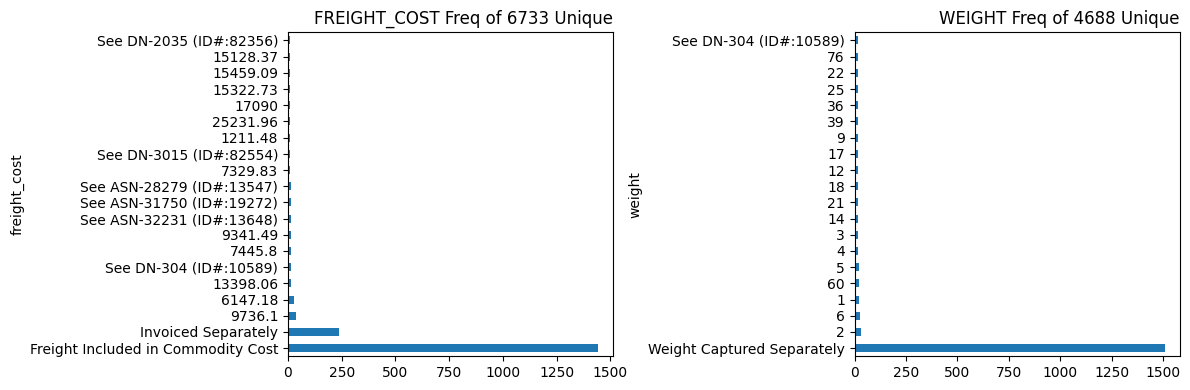

In [317]:
print(dobject)
scmhelper.plotFreq(dobject, ['freight_cost', 'weight'], cutoff=20)

In [318]:
# Convert all numbers to floats, transform all numbers to numeric, deal strings later below...
fwcols = ['freight_cost','weight']
for c in fwcols:
    dobject[c]=dobject[c].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
    print("\nType Counts for: {}, \n{}".format(c,
        pd.Series([type(x) for x in dobject['freight_cost']]).value_counts()))


Type Counts for: freight_cost, 
<class 'float'>    5734
<class 'str'>      4126
<class 'int'>       464
Name: count, dtype: int64

Type Counts for: weight, 
<class 'float'>    5734
<class 'str'>      4126
<class 'int'>       464
Name: count, dtype: int64


#### Initial observations..
We can see a few things:

- for freight_cost 
    - about 1500 times the freight is included in the commodity cost
    - About 250 times the freight is invoiced separately
    - Several entries have a reference instead of amount. 
        - This reference can occurs many times, find out what it means..
    - The rest of the entries are numerical as expected: a mixture of integers and floats
- for weight: 
    - About 1500 times the weight was captured seperately
    - the rest are mostly integers
    
    ===========

- First Line Designation	
    - Designates if the line in question shows the aggregated freight costs and weight associated with all items on the ASN/DN .There may or may not be other associated lines with each ASN/DN
- Weight (Kilograms)
    - Weight for all lines on an ASN/DN	Present only for FirstLine designated lines
- Freight Cost (USD)
    - Freight charges associated with all lines on the respective ASN/DN	Present only for FirstLine designated lines. For C- and D-vendor INCO term deliveries, freight costs may be included in the unit price for the commodities as indicated by "Freight Included in Commodity Price". All other lines are "Invoiced Separately"

#### Get more insight into the freight and weight columns

In [319]:
for c in fwcols:
    print("\n---",c+"\n",dobject[c].apply(lambda x: x if type(x)== str else 1).value_counts()[:8])


--- freight_cost
 freight_cost
1                                     6198
Freight Included in Commodity Cost    1442
Invoiced Separately                    239
See DN-304 (ID#:10589)                  16
See ASN-31750 (ID#:19272)               14
See ASN-32231 (ID#:13648)               14
See ASN-28279 (ID#:13547)               13
See DN-3015 (ID#:82554)                 12
Name: count, dtype: int64

--- weight
 weight
1                             6372
Weight Captured Separately    1507
See DN-304 (ID#:10589)          16
See ASN-32231 (ID#:13648)       14
See ASN-31750 (ID#:19272)       14
See ASN-28279 (ID#:13547)       13
See DN-3015 (ID#:82554)         12
See DN-2035 (ID#:82356)         10
Name: count, dtype: int64


<Axes: ylabel='itm_desc'>

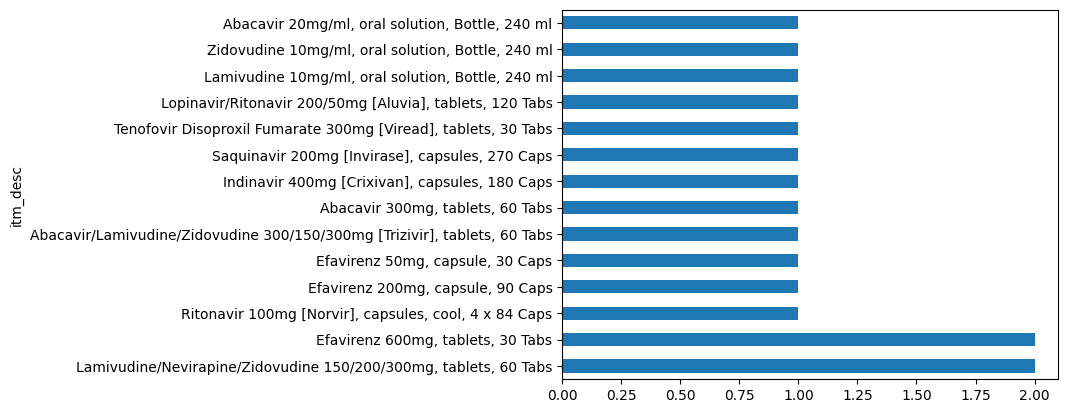

In [320]:
# Let's see an example for weight
dobject[dobject['weight'] == 'See DN-304 (ID#:10589)']['itm_desc'].value_counts().plot(
    kind='barh')

<Axes: ylabel='factory'>

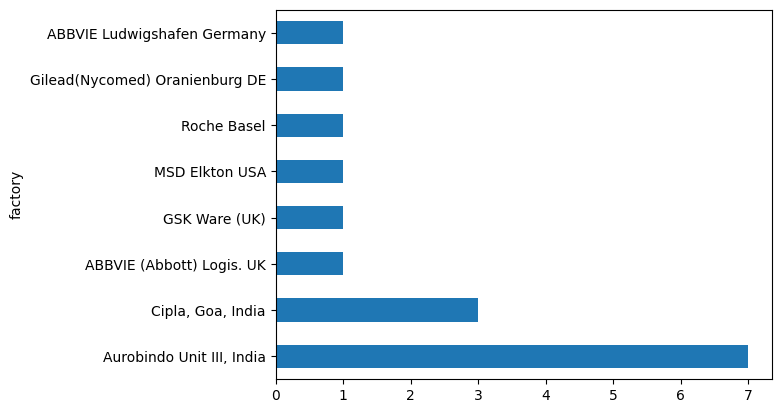

In [321]:
# Let's see an example for weight
dobject[dobject['weight'] == 'See DN-304 (ID#:10589)']['factory'].value_counts().plot(
    kind='barh')

In [322]:
# This is the top line item with the weight data for all the ones above..
# Weight is bundled/consolidated
print("/n Weight: ", dobject[dint['id']==10589].weight)

/n Weight:  1056    9006
Name: weight, dtype: object


In [323]:
# Let's see an example for freight cost
dobject[dobject['freight_cost'] == 'See ASN-31750 (ID#:19272)'].head()

,proj_code,pq_no,po_no,ship_no,country,mngr,fulfill_via,vendor_terms,ship_mode,pq_date,...,vendor,itm_desc,molecule_test,brand,dosage,dosage_form,factory,first_line,weight,freight_cost
3623,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Air Charter,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)
4041,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Truck,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)
4057,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Truck,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)
4157,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Air,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)
4448,101-CD-T30,FPQ-16001,SCMS-280210,ASN-31750,"Congo, DRC",PMO - US,Direct Drop,EXW,Air Charter,2015-03-10 00:00:00,...,"Trinity Biotech, Plc","HIV 1/2, Uni-Gold HIV Kit, 20 Tests","HIV 1/2, Uni-Gold HIV Kit",Uni-Gold,TestKit/Ancillary,Test kit,"Trinity Biotech, Plc",No,See ASN-31750 (ID#:19272),See ASN-31750 (ID#:19272)


In [324]:
# This is the top line item with the freight cost for all the ones above..
print(dobject[dint['id']==19272], "/nFreight Cost: ", dobject[dint['id']==19272].freight_cost)

       proj_code      pq_no        po_no    ship_no     country      mngr  \
3014  101-CD-T30  FPQ-16001  SCMS-280210  ASN-31750  Congo, DRC  PMO - US   

      fulfill_via vendor_terms ship_mode              pq_date  ...  \
3014  Direct Drop          EXW     Truck  2015-03-10 00:00:00  ...   

                    vendor                             itm_desc  \
3014  Trinity Biotech, Plc  HIV 1/2, Uni-Gold HIV Kit, 20 Tests   

                  molecule_test     brand             dosage dosage_form  \
3014  HIV 1/2, Uni-Gold HIV Kit  Uni-Gold  TestKit/Ancillary    Test kit   

                   factory first_line weight freight_cost  
3014  Trinity Biotech, Plc        Yes    508      3918.37  

[1 rows x 23 columns] /nFreight Cost:  3014    3918.37
Name: freight_cost, dtype: object


#### Weight - new estimates 

In [325]:
#Alternatively...use ship numbers to make dict
bundled_itms =dobject.groupby('ship_no').filter(lambda x: len(x)>1)
print("all bundled : ", bundled_itms.shape)
unbundled_itms = dobject.groupby('ship_no').filter(lambda x: len(x)==1)
print("all unbundled: ",unbundled_itms.shape,"\n----\n")
print("Unbundled Items Top Freq: \n----\n {},Bundled Items Top Freq: \n----\n {} ".format(unbundled_itms.weight.value_counts()[:5]
,bundled_itms.weight.value_counts()[:5]))

all bundled :  (4744, 23)
all unbundled:  (5580, 23) 
----

Unbundled Items Top Freq: 
----
 weight
Weight Captured Separately    465
2                              29
6                              24
1                              23
60                             20
Name: count, dtype: int64,Bundled Items Top Freq: 
----
 weight
Weight Captured Separately    1042
See DN-304 (ID#:10589)          16
See ASN-32231 (ID#:13648)       14
See ASN-31750 (ID#:19272)       14
See ASN-28279 (ID#:13547)       13
Name: count, dtype: int64 


In [326]:
# Find those with weight captured separately
sep_weight_bundled = bundled_itms[bundled_itms.weight== 'Weight Captured Separately']
print("only bundled separate weight: ",sep_weight_bundled.shape)
sep_weight_single = unbundled_itms[unbundled_itms.weight== 'Weight Captured Separately']
print("only single separate weight: ",sep_weight_single.shape)

only bundled separate weight:  (1042, 23)
only single separate weight:  (465, 23)


In [327]:
# Seperate out the single, topline and bottom items..
single_itms = unbundled_itms.drop(list(sep_weight_single.index),axis=0)
print("only single: ",single_itms.shape)
bundled_no_sep_weight = bundled_itms.drop(list(sep_weight_bundled.index),axis=0)
top_itms = bundled_no_sep_weight[[type(x)==int for x in bundled_no_sep_weight.weight]]
print("only topline: ",top_itms.shape)
bottom_itms = bundled_no_sep_weight.drop(top_itms.index)
print("only bottom items :",bottom_itms.shape)

only single:  (5115, 23)
only topline:  (1257, 23)
only bottom items : (2445, 23)


In [328]:
# Check the math, should both equal 10234
print("Check, must both equal n=10234 \n---\n",top_itms.shape[0] + bottom_itms.shape[0] + single_itms.shape[0] + sep_weight_single.shape[0] + sep_weight_bundled.shape[0])
print(bundled_itms.shape[0] + unbundled_itms.shape[0])

Check, must both equal n=10234 
---
 10324
10324


#### Finally, merged with dataframe based on lookup table

#### Calculate Average Weight per Item

In [329]:
# Make weight lookup dictionary to cover all product item scenarios
w_lkup = single_itms[['itm_desc','weight','molecule_test', 'dosage_form']]
w_lkup['weight'] = pd.to_numeric(w_lkup.weight)
w_lkup['ln_itm_qty'] = dint.loc[list(w_lkup.index),:]['ln_itm_qty']
w_lkup['units'] = dint.loc[list(w_lkup.index),:]['units']
w_lkup['itm_weight'] = w_lkup.weight/w_lkup.ln_itm_qty
print(w_lkup.shape, w_lkup.columns)

# Make lookup tables for each case, in order..
w_lkup_itm = w_lkup.groupby('itm_desc').mean(numeric_only=True).reset_index()[['itm_desc', 'itm_weight']]
w_lkup_mol = w_lkup.groupby('molecule_test').mean(numeric_only=True).reset_index()[['molecule_test', 'itm_weight']]
w_lkup_dos = w_lkup.groupby('dosage_form').mean(numeric_only=True).reset_index()[['dosage_form', 'itm_weight']]

merge_itm = pd.merge(dobject, w_lkup_itm, how='left', left_on='itm_desc', right_on='itm_desc')
merge_mol = pd.merge(merge_itm, w_lkup_mol, how='left', left_on='molecule_test'
                     , right_on='molecule_test')
merge_dos = pd.merge(merge_mol, w_lkup_dos, how='left', left_on='dosage_form'
                     , right_on='dosage_form')
print(merge_itm.shape, merge_mol.shape, merge_dos.shape)

(5115, 7) Index(['itm_desc', 'weight', 'molecule_test', 'dosage_form', 'ln_itm_qty',
       'units', 'itm_weight'],
      dtype='object')
(10324, 24) (10324, 25) (10324, 26)


In [330]:
print(" Nulls at starting point: ", merge_dos.itm_weight_x.isnull().sum())
w1 = merge_dos.itm_weight_x.notnull()
merge_dos['itm_weight_new'] =merge_dos.itm_weight_x.where(w1
                                                                ,merge_dos.itm_weight_y)
print(" Nulls at midpoint...: ", merge_dos.itm_weight_new.isnull().sum())
w2 = merge_dos.itm_weight_new.notnull()
merge_dos['itm_weight_new'] = merge_dos.itm_weight_new.where(w2
                                                                ,merge_dos.itm_weight)
print(" Nulls at endpoint: ", merge_dos.itm_weight_new.isnull().sum())
dobject = merge_dos[['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost',
        #'itm_weight_x', 'itm_weight_y', 'itm_weight',
       'itm_weight_new']]

 Nulls at starting point:  241
 Nulls at midpoint...:  49
 Nulls at endpoint:  0


#### Calculate the real weight of items and move it to the float dictionary

In [331]:
dfloat['ln_itm_weight'] = dint['ln_itm_qty']*dobject['itm_weight_new']
# drop it in the dobject
dobject.drop(['itm_weight_new'
             # ,'weight'
             ], axis=1, inplace=True)
dfloat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ln_itm_val     10324 non-null  float64
 1   pk_price       10324 non-null  float64
 2   unit_price     10324 non-null  float64
 3   line_itm_ins   10324 non-null  float64
 4   ln_itm_weight  10324 non-null  float64
dtypes: float64(5)
memory usage: 403.4 KB


#### Freight Cost - new estimate

In [332]:
dobject.freight_cost.value_counts()[:5]

freight_cost
Freight Included in Commodity Cost    1442
Invoiced Separately                    239
9736.1                                  36
6147.18                                 27
13398.06                                16
Name: count, dtype: int64

In [333]:
# FC Invoiced Seperately
sep_freight_cost_bundled = bundled_itms[bundled_itms.freight_cost== 'Invoiced Separately']
print("only bundled separate freight_cost: ",sep_freight_cost_bundled.shape)
sep_freight_cost_single = unbundled_itms[unbundled_itms.freight_cost== 'Invoiced Separately']
print("only single separate freight_cost: ",sep_freight_cost_single.shape)
# FC Included in Commodity Costs
included_freight_cost_bundled = bundled_itms[bundled_itms.freight_cost== 'Freight Included in Commodity Cost']
print("only bundled freight_cost in commodity cost: ",included_freight_cost_bundled.shape)
included_freight_cost_single = unbundled_itms[unbundled_itms.freight_cost== 'Freight Included in Commodity Cost']
print("only single freight_cost in commodity cost: ",included_freight_cost_single.shape)

only bundled separate freight_cost:  (58, 23)
only single separate freight_cost:  (181, 23)
only bundled freight_cost in commodity cost:  (1000, 23)
only single freight_cost in commodity cost:  (442, 23)


In [334]:
single_itms.freight_cost.value_counts()[:3]

freight_cost
Freight Included in Commodity Cost    173
9736.1                                 35
6147.18                                27
Name: count, dtype: int64

In [335]:
top_itms.freight_cost.value_counts()[:3]

freight_cost
Freight Included in Commodity Cost    23
17090                                  6
16532.5                                4
Name: count, dtype: int64

In [336]:
bottom_itms.freight_cost.value_counts()[:3]

freight_cost
See DN-304 (ID#:10589)       16
See ASN-32231 (ID#:13648)    14
See ASN-31750 (ID#:19272)    14
Name: count, dtype: int64

In [337]:
# Seperate out the single, topline and bottom items..
single_itms_fc = single_itms.drop(list(
single_itms[single_itms.freight_cost=='Freight Included in Commodity Cost'].index),axis=0)
print("only single: ",single_itms_fc.shape)
top_itms_fc = top_itms.drop(list(
    top_itms[top_itms.freight_cost=='Freight Included in Commodity Cost'].index), axis=0)
print("only topline: ",top_itms_fc.shape)
bottom_itms_fc = bottom_itms
print("only bottom items :",bottom_itms_fc.shape)

only single:  (4942, 23)
only topline:  (1234, 23)
only bottom items : (2445, 23)


#### Finally, merged with dataframe based on lookup table

#### Calculate Average Freight_cost per Item **weight**

In [338]:
# Make freight_cost lookup dictionary to cover all product item scenarios
f_lkup = single_itms_fc[['itm_desc','freight_cost','molecule_test', 'dosage_form']]
f_lkup['freight_cost'] = pd.to_numeric(f_lkup.freight_cost)
f_lkup['ln_itm_weight'] = dfloat.loc[list(f_lkup.index),:]['ln_itm_weight']
f_lkup['itm_freight_cost'] = f_lkup.freight_cost/f_lkup.ln_itm_weight
print(f_lkup.shape, f_lkup.columns)
# Make lookup tables for each case, in order..
f_lkup_itm = f_lkup.groupby('itm_desc').mean(numeric_only=True).reset_index()[['itm_desc', 'itm_freight_cost']]
f_lkup_mol = f_lkup.groupby('molecule_test').mean(numeric_only=True).reset_index()[['molecule_test', 'itm_freight_cost']]
f_lkup_dos = f_lkup.groupby('dosage_form').mean(numeric_only=True).reset_index()[['dosage_form', 'itm_freight_cost']]
# Merge
fmerge_itm = pd.merge(dobject, f_lkup_itm, how='left', left_on='itm_desc', right_on='itm_desc')
fmerge_mol = pd.merge(fmerge_itm, f_lkup_mol, how='left', left_on='molecule_test'
                     , right_on='molecule_test')
fmerge_dos = pd.merge(fmerge_mol, f_lkup_dos, how='left', left_on='dosage_form'
                     , right_on='dosage_form')
print(fmerge_itm.shape, fmerge_mol.shape, fmerge_dos.shape)

(4942, 6) Index(['itm_desc', 'freight_cost', 'molecule_test', 'dosage_form',
       'ln_itm_weight', 'itm_freight_cost'],
      dtype='object')
(10324, 24) (10324, 25) (10324, 26)


In [339]:
print(" Nulls at starting point: ", fmerge_dos.itm_freight_cost_x.isnull().sum())
w1 = fmerge_dos.itm_freight_cost_x.notnull()
fmerge_dos['itm_freight_cost_new'] =fmerge_dos.itm_freight_cost_x.where(w1
                                                                ,fmerge_dos.itm_freight_cost_y)
print(" Nulls at midpoint...: ", fmerge_dos.itm_freight_cost_new.isnull().sum())
w2 = fmerge_dos.itm_freight_cost_new.notnull()
fmerge_dos['itm_freight_cost_new'] = fmerge_dos.itm_freight_cost_new.where(w2
                                                                ,fmerge_dos.itm_freight_cost)
print(" Nulls at endpoint: ", fmerge_dos.itm_freight_cost_new.isnull().sum())
dobject = fmerge_dos[['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 
       #'itm_freight_cost_x', 'itm_freight_cost_y', 'itm_freight_cost',
       'itm_freight_cost_new']]

 Nulls at starting point:  245
 Nulls at midpoint...:  49
 Nulls at endpoint:  0


In [340]:
#### Now Calculate the real freight_cost of items and move it to the float dictionary
dfloat['ln_itm_freight_cost'] = dfloat['ln_itm_weight']*dobject['itm_freight_cost_new']
# drop it in the dobject
dobject.drop(['itm_freight_cost_new'
             # ,'freight_cost'
             ], axis=1, inplace=True)
dfloat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ln_itm_val           10324 non-null  float64
 1   pk_price             10324 non-null  float64
 2   unit_price           10324 non-null  float64
 3   line_itm_ins         10324 non-null  float64
 4   ln_itm_weight        10324 non-null  float64
 5   ln_itm_freight_cost  10324 non-null  float64
dtypes: float64(6)
memory usage: 484.1 KB


#### **Data notes:** Relationships in the cost, price and freight cost features

**1. pk_price = unit_price * units **
    - calculate pk_price_alt because this is not always the case
    - might find some data entry errors
    - implications of discounts 
**2. ln_itm_val = ln_itm_qty * pk_price **
    - checks out for most of the entries
    - double-check
    
**3. Freight must be proportionally related to weight **
    - broad assumption, but should work if average line item weight per unit is used
    - This is then multiplied by the item weight to get the ln_itm_freight_cost 

----
## 2. Feature Engineering
----

### Feature Extraction

#### Dates

##### Year, Month and Day from  the date columns to the Object columns 
##### Businessday/Weekend, Financial Quarter etc. 

In [341]:
# Make the lists first, thank you, list comprehension!!
# Refactor code later to function, can automate which time-period gets added
datecolumns =['pq_date_new', 'po_date_new', 'del_date_scheduled'
              , 'del_date_client','del_date_recorded']
lists_yr=[list(ddate[c].dt.year) for c in datecolumns] # Use .dt function!!
lists_mn=[list(ddate[c].dt.month) for c in datecolumns] # Use .dt function!!
lists_dy=[list(ddate[c].dt.day) for c in datecolumns] # Use .dt function!!
print(len(lists_yr), len(lists_mn),len(lists_dy))
print(len(lists_yr[0]), len(lists_mn[2]),len(lists_dy[4]))
# Remember to cast these as categories later! 
date_list_of_lists = [lists_yr, lists_mn, lists_dy]
date_suffix = ['yr', 'mn', 'dy']
for c in datecolumns:
    j = datecolumns.index(c)
    for i in range(len(date_list_of_lists)):
        name = str(c)+str("_")+str(date_suffix[i])
        # Make sure to convert to categorical
        dobject[name] = pd.Categorical(date_list_of_lists[i][j])
print(dobject.shape,dobject.columns)
dobject.info()
'''# 'ddate' is your DataFrame containing the datetime columns.
# Let's ensure these columns are in datetime format (necessary if not already done).
datecolumns = ['pq_date_new', 'po_date_new', 'del_date_scheduled', 'del_date_client', 'del_date_recorded']
ddate[datecolumns] = ddate[datecolumns].apply(pd.to_datetime)

# Initialize an empty DataFrame or a dict to store the categorical data.
# It could be a new DataFrame or an existing one where you want to add the new columns.
dobject = pd.DataFrame()

# Iterating through each date column to extract year, month, and day
date_suffix = ['yr', 'mn', 'dy']
for c in datecolumns:
    # Extracting year, month, and day and converting them to categorical directly
    dobject[c + "_yr"] = pd.Categorical(ddate[c].dt.year)
    dobject[c + "_mn"] = pd.Categorical(ddate[c].dt.month)
    dobject[c + "_dy"] = pd.Categorical(ddate[c].dt.day)

# Display the structure and columns of the resulting DataFrame
print(dobject.shape, dobject.columns)
dobject.info()'''

5 5 5
10324 10324 10324
(10324, 38) Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 'pq_date_new_yr', 'pq_date_new_mn', 'pq_date_new_dy',
       'po_date_new_yr', 'po_date_new_mn', 'po_date_new_dy',
       'del_date_scheduled_yr', 'del_date_scheduled_mn',
       'del_date_scheduled_dy', 'del_date_client_yr', 'del_date_client_mn',
       'del_date_client_dy', 'del_date_recorded_yr', 'del_date_recorded_mn',
       'del_date_recorded_dy'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   proj_code              10324 non-null  object  
 1   p

'# \'ddate\' is your DataFrame containing the datetime columns.\n# Let\'s ensure these columns are in datetime format (necessary if not already done).\ndatecolumns = [\'pq_date_new\', \'po_date_new\', \'del_date_scheduled\', \'del_date_client\', \'del_date_recorded\']\nddate[datecolumns] = ddate[datecolumns].apply(pd.to_datetime)\n\n# Initialize an empty DataFrame or a dict to store the categorical data.\n# It could be a new DataFrame or an existing one where you want to add the new columns.\ndobject = pd.DataFrame()\n\n# Iterating through each date column to extract year, month, and day\ndate_suffix = [\'yr\', \'mn\', \'dy\']\nfor c in datecolumns:\n    # Extracting year, month, and day and converting them to categorical directly\n    dobject[c + "_yr"] = pd.Categorical(ddate[c].dt.year)\n    dobject[c + "_mn"] = pd.Categorical(ddate[c].dt.month)\n    dobject[c + "_dy"] = pd.Categorical(ddate[c].dt.day)\n\n# Display the structure and columns of the resulting DataFrame\nprint(dobject.s

In [342]:
# Make businessday, monthend, and quarterly features
datecolumns =['pq_date_new', 'po_date_new', 'del_date_scheduled'
              , 'del_date_client','del_date_recorded']
lists_wd=[list(ddate[c].dt.weekday) for c in datecolumns] # Use .dt function!!
lists_wk=[list(ddate[c].dt.isocalendar().week) for c in datecolumns] # Use .dt function!!
lists_qt=[list(ddate[c].dt.quarter) for c in datecolumns] # Use .dt function!!
print(len(lists_wd), len(lists_wk),len(lists_qt))
print(len(lists_wd[0]), len(lists_wk[2]),len(lists_qt[4]))

# Remember to cast these as categories later! 
date_list_of_lists = [lists_wd, lists_wk, lists_qt]
date_suffix = ['wd', 'wk', 'qt']
for c in datecolumns:
    j = datecolumns.index(c)
    for i in range(len(date_list_of_lists)):
        name = str(c)+str("_")+str(date_suffix[i])
        # Make sure to convert to categorical
        dobject[name] = pd.Categorical(date_list_of_lists[i][j])
print(dobject.shape,dobject.columns)
dobject.info()

5 5 5
10324 10324 10324
(10324, 53) Index(['proj_code', 'pq_no', 'po_no', 'ship_no', 'country', 'mngr',
       'fulfill_via', 'vendor_terms', 'ship_mode', 'pq_date', 'po_date',
       'prod_grp', 'sub_class', 'vendor', 'itm_desc', 'molecule_test', 'brand',
       'dosage', 'dosage_form', 'factory', 'first_line', 'weight',
       'freight_cost', 'pq_date_new_yr', 'pq_date_new_mn', 'pq_date_new_dy',
       'po_date_new_yr', 'po_date_new_mn', 'po_date_new_dy',
       'del_date_scheduled_yr', 'del_date_scheduled_mn',
       'del_date_scheduled_dy', 'del_date_client_yr', 'del_date_client_mn',
       'del_date_client_dy', 'del_date_recorded_yr', 'del_date_recorded_mn',
       'del_date_recorded_dy', 'pq_date_new_wd', 'pq_date_new_wk',
       'pq_date_new_qt', 'po_date_new_wd', 'po_date_new_wk', 'po_date_new_qt',
       'del_date_scheduled_wd', 'del_date_scheduled_wk',
       'del_date_scheduled_qt', 'del_date_client_wd', 'del_date_client_wk',
       'del_date_client_qt', 'del_date_recorded_w

In [343]:
### Numerical Columns
print(dint.columns,"\n", dfloat.columns,"\n",blocks.keys())

Index(['id', 'units', 'ln_itm_qty'], dtype='object') 
 Index(['ln_itm_val', 'pk_price', 'unit_price', 'line_itm_ins', 'ln_itm_weight',
       'ln_itm_freight_cost'],
      dtype='object') 
 dict_keys([dtype('int64'), dtype('O'), dtype('<M8[ns]'), dtype('float64')])


In [344]:
# Join dint and dfloat in to dnum?
dnum = pd.concat([dint, dfloat], axis=1)
print(dnum.shape); dnum.head()

(10324, 9)


,id,units,ln_itm_qty,ln_itm_val,pk_price,unit_price,line_itm_ins,ln_itm_weight,ln_itm_freight_cost
0,1,30,19,551.0,29.00,0.97,0.00245,13.000000,819.935000
1,3,240,1000,6200.0,6.20,0.03,0.00245,368.830071,2335.540207
2,4,100,500,40000.0,80.00,0.80,0.00245,10671.152042,92778.636389
3,15,60,31920,127360.8,3.99,0.07,0.00245,1916.285060,856061.478787
4,16,60,38000,121600.0,3.20,0.05,0.00245,3159.972544,73767.191447



#### *Counts, Sums, Proportions, and Measures of Central Tendency*

In [345]:
import pandas as pd

# Assuming 'dobject' and 'dnum' DataFrames exist and are correctly formatted.
# 'entities' list contains the columns to group by.
entities = ['country', 'factory', 'vendor', 'molecule_test', 'brand']

# 'n_measures' list contains the numeric columns for aggregation.
n_measures = ['ln_itm_qty', 'ln_itm_val', 'line_itm_ins', 'ln_itm_weight', 'ln_itm_freight_cost']

# Initialize list for storing stats DataFrames.
stats_dfs = [None] * len(entities)

# Loop through each entity to calculate grouped statistics.
for i, entity in enumerate(entities):
    # Concatenate 'dobject' with selected measures from 'dnum', then group by entity and year.
    group_df = pd.concat([dobject[[entity, 'del_date_scheduled_yr']], dnum[n_measures]], axis=1).groupby([entity, 'del_date_scheduled_yr'])
    
    # Aggregate data with 'sum', 'count', 'mean'.
    agg_df = group_df.agg(['sum', 'count', 'mean'])
    
    # Rename columns by combining measures with aggregation methods.
    agg_df.columns = [f"{measure}_{agg}" for measure, agg in agg_df.columns]
    
    # Reset index to make grouping columns regular columns.
    agg_df.reset_index(inplace=True)
    
    # Store the aggregated DataFrame.
    stats_dfs[i] = agg_df

# Print shapes and column names of the aggregated DataFrames for verification.
print([df.shape for df in stats_dfs])
print("\n------\n", [df.columns for df in stats_dfs])

# Initialize list for storing merged DataFrames.
joins = [None] * len(entities)

# Merge original data with aggregated stats for each entity.
for i, entity in enumerate(entities):
    # Copy relevant columns from 'dobject' and merge with aggregated stats.
    base_df = dobject[entities + ['del_date_scheduled_yr']].copy()
    joins[i] = pd.merge(base_df, stats_dfs[i], on=[entity, 'del_date_scheduled_yr'], how='left')

# Example to print shapes to verify merges.
for i, join in enumerate(joins):
    print(f"Join {i}: {join.shape}")


[(430, 17), (880, 17), (730, 17), (860, 17), (480, 17)]

------
 [Index(['country', 'del_date_scheduled_yr', 'ln_itm_qty_sum',
       'ln_itm_qty_count', 'ln_itm_qty_mean', 'ln_itm_val_sum',
       'ln_itm_val_count', 'ln_itm_val_mean', 'line_itm_ins_sum',
       'line_itm_ins_count', 'line_itm_ins_mean', 'ln_itm_weight_sum',
       'ln_itm_weight_count', 'ln_itm_weight_mean', 'ln_itm_freight_cost_sum',
       'ln_itm_freight_cost_count', 'ln_itm_freight_cost_mean'],
      dtype='object'), Index(['factory', 'del_date_scheduled_yr', 'ln_itm_qty_sum',
       'ln_itm_qty_count', 'ln_itm_qty_mean', 'ln_itm_val_sum',
       'ln_itm_val_count', 'ln_itm_val_mean', 'line_itm_ins_sum',
       'line_itm_ins_count', 'line_itm_ins_mean', 'ln_itm_weight_sum',
       'ln_itm_weight_count', 'ln_itm_weight_mean', 'ln_itm_freight_cost_sum',
       'ln_itm_freight_cost_count', 'ln_itm_freight_cost_mean'],
      dtype='object'), Index(['vendor', 'del_date_scheduled_yr', 'ln_itm_qty_sum', 'ln_itm_qty_coun

In [346]:
dnum.head()

,id,units,ln_itm_qty,ln_itm_val,pk_price,unit_price,line_itm_ins,ln_itm_weight,ln_itm_freight_cost
0,1,30,19,551.0,29.00,0.97,0.00245,13.000000,819.935000
1,3,240,1000,6200.0,6.20,0.03,0.00245,368.830071,2335.540207
2,4,100,500,40000.0,80.00,0.80,0.00245,10671.152042,92778.636389
3,15,60,31920,127360.8,3.99,0.07,0.00245,1916.285060,856061.478787
4,16,60,38000,121600.0,3.20,0.05,0.00245,3159.972544,73767.191447


In [347]:
entities = ['country'  # high-volume countries? high freight cost?
            , 'factory' # slow factories, small factories? high freight cost?
            , 'vendor' # incompetent vendors? high freight cost?
            , 'molecule_test' # trade hurdles? high freight cost?
           , 'brand' # shipment quotas? brand troubles?
           ] 
# Make list of dfs to be populated
stats_dfs = [None,None,None,None,None]
# Must do this by year to allow for dynamic measures
n_measures = ['ln_itm_qty', 'ln_itm_val', 'line_itm_ins'
                , 'ln_itm_weight', 'ln_itm_freight_cost']
joins =[None,None,None,None,None]
# Populate the grouped stats dfs
for i in range(len(entities)):
    numeric_cols = dnum[n_measures].select_dtypes(include=np.number).columns.tolist()

    # Create a dictionary for aggregation
    # 'count' can be applied universally, but 'sum' and 'mean' should only be applied to numeric columns
    agg_dict = {col: ['sum', 'count', 'mean'] for col in numeric_cols}
    # Add a 'count' operation for a non-numeric column to maintain row counts
    # This assumes there's at least one non-numeric column in dobject or you can use any other column
    #agg_dict['some_non_numeric_column'] = ['count']

    print(pd.concat([dobject,dnum[n_measures]], axis=1)['del_date_scheduled_yr'])
    #stats_dfs[i] = pd.concat([dobject,dnum[n_measures]], axis=1).groupby([entities[i], 'del_date_scheduled_yr']).agg(['sum', 'count', 'mean'])
    stats_dfs[i] = pd.concat([dobject, dnum[n_measures]], axis=1).groupby([entities[i], 'del_date_scheduled_yr']).agg(agg_dict)
    stats_dfs[i].columns = [entities[i]+"_"+str(x[0]+x[1]).split("_")[-1] for x in stats_dfs[i].columns]
    stats_dfs[i].reset_index(inplace=True)    

print([x.shape for x in stats_dfs])
print("\n------\n",[x.columns for x in stats_dfs])

for i in range(len(entities)):
    print(i)
    a= dobject[entities+['del_date_scheduled_yr']].copy()
    joins[i] = pd.merge(a, stats_dfs[i],
            left_on=[entities[i],'del_date_scheduled_yr']
                 , right_on=[entities[i],'del_date_scheduled_yr'])

0        2006
1        2006
2        2006
3        2006
4        2006
         ... 
10319    2015
10320    2015
10321    2015
10322    2015
10323    2015
Name: del_date_scheduled_yr, Length: 10324, dtype: category
Categories (10, int64): [2006, 2007, 2008, 2009, ..., 2012, 2013, 2014, 2015]
0        2006
1        2006
2        2006
3        2006
4        2006
         ... 
10319    2015
10320    2015
10321    2015
10322    2015
10323    2015
Name: del_date_scheduled_yr, Length: 10324, dtype: category
Categories (10, int64): [2006, 2007, 2008, 2009, ..., 2012, 2013, 2014, 2015]
0        2006
1        2006
2        2006
3        2006
4        2006
         ... 
10319    2015
10320    2015
10321    2015
10322    2015
10323    2015
Name: del_date_scheduled_yr, Length: 10324, dtype: category
Categories (10, int64): [2006, 2007, 2008, 2009, ..., 2012, 2013, 2014, 2015]
0        2006
1        2006
2        2006
3        2006
4        2006
         ... 
10319    2015
10320    2015
10321    201

In [348]:
dnum.head()

,id,units,ln_itm_qty,ln_itm_val,pk_price,unit_price,line_itm_ins,ln_itm_weight,ln_itm_freight_cost
0,1,30,19,551.0,29.00,0.97,0.00245,13.000000,819.935000
1,3,240,1000,6200.0,6.20,0.03,0.00245,368.830071,2335.540207
2,4,100,500,40000.0,80.00,0.80,0.00245,10671.152042,92778.636389
3,15,60,31920,127360.8,3.99,0.07,0.00245,1916.285060,856061.478787
4,16,60,38000,121600.0,3.20,0.05,0.00245,3159.972544,73767.191447


In [349]:
joined = pd.concat(joins, axis=1)
print("joined shape: ", joined.shape)
joined=joined.drop(entities+['del_date_scheduled_yr'], axis=1)
print("joined shape: ", joined.shape)
print("joined columns: ", joined.columns.tolist())

joined shape:  (10324, 105)
joined shape:  (10324, 75)
joined columns:  ['country_qtysum', 'country_qtycount', 'country_qtymean', 'country_valsum', 'country_valcount', 'country_valmean', 'country_inssum', 'country_inscount', 'country_insmean', 'country_weightsum', 'country_weightcount', 'country_weightmean', 'country_costsum', 'country_costcount', 'country_costmean', 'factory_qtysum', 'factory_qtycount', 'factory_qtymean', 'factory_valsum', 'factory_valcount', 'factory_valmean', 'factory_inssum', 'factory_inscount', 'factory_insmean', 'factory_weightsum', 'factory_weightcount', 'factory_weightmean', 'factory_costsum', 'factory_costcount', 'factory_costmean', 'vendor_qtysum', 'vendor_qtycount', 'vendor_qtymean', 'vendor_valsum', 'vendor_valcount', 'vendor_valmean', 'vendor_inssum', 'vendor_inscount', 'vendor_insmean', 'vendor_weightsum', 'vendor_weightcount', 'vendor_weightmean', 'vendor_costsum', 'vendor_costcount', 'vendor_costmean', 'molecule_test_qtysum', 'molecule_test_qtycount', '

In [350]:
# Now merge to make numerical columns for each entity
dnum_country, dnum_factory, dnum_vendor, dnum_molecule_test, dnum_brand = joins
dnum_vendor.head()

,country,factory,vendor,molecule_test,brand,del_date_scheduled_yr,vendor_qtysum,vendor_qtycount,vendor_qtymean,vendor_valsum,...,vendor_valmean,vendor_inssum,vendor_inscount,vendor_insmean,vendor_weightsum,vendor_weightcount,vendor_weightmean,vendor_costsum,vendor_costcount,vendor_costmean
0,Côte d'Ivoire,Ranbaxy Fine Chemicals LTD,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,2006,38,2,19.000000,1102.00,...,551.000000,0.00490,2,0.00245,26.000000,2,13.000000,1.639870e+03,2,819.935000
1,Vietnam,"Aurobindo Unit III, India",Aurobindo Pharma Limited,Nevirapine,Generic,2006,334157,25,13366.280000,2999909.93,...,119996.397200,0.06125,25,0.00245,29812.978192,25,1192.519128,9.469516e+05,25,37878.064238
2,Côte d'Ivoire,ABBVIE GmbH & Co.KG Wiesbaden,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,2006,9880,12,823.333333,790400.00,...,65866.666667,0.02940,12,0.00245,210861.964342,12,17571.830362,1.833306e+06,12,152775.487921
3,Vietnam,"Ranbaxy, Paonta Shahib, India",SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,2006,40349,3,13449.666667,156929.15,...,52309.716667,0.00735,3,0.00245,2422.311588,3,807.437196,1.082119e+06,3,360706.188467
4,Vietnam,"Aurobindo Unit III, India",Aurobindo Pharma Limited,Stavudine,Generic,2006,334157,25,13366.280000,2999909.93,...,119996.397200,0.06125,25,0.00245,29812.978192,25,1192.519128,9.469516e+05,25,37878.064238


#### Categorical
#### *Weight captured seperately, shipment configuration*

In [351]:
# Shipment configuration
dobject['ship_config'] = None
ship_list = [(top_itms.index,"bundled-topline"),(bottom_itms.index,"bundled-bottom") 
, (single_itms.index,"single") ,(sep_weight_single.index, "single-seperate-weight")
            ,(sep_weight_bundled.index, "bundled-seperate-weight")]
for k, v in ship_list:
    dobject.loc[list(k),'ship_config'] = v 
dobject['ship_config'].value_counts()

# Weight Captured Seperately
dobject['weight_captured_seperately'] = "No"
sep_idx = list(sep_weight_single.index) + list(sep_weight_bundled.index)
dobject.loc[sep_idx, 'weight_captured_seperately'] = "Yes"
dobject['weight_captured_seperately'].value_counts()

weight_captured_seperately
No     8817
Yes    1507
Name: count, dtype: int64

#### Categorical
#### *Freight cost invoicing and cost inclusive*

In [352]:
# Freight_cost Invoiced Seperately
dobject['freight_invoiced_seperately'] = "No"
is_idx = list(dobject[dobject.freight_cost=='Invoiced Separately'].index)
dobject.loc[is_idx, 'freight_invoiced_seperately'] = "Yes"
dobject['freight_invoiced_seperately'].value_counts()
#  or included in commodity cost
dobject['freight_in_cmdty_cost'] = "No"
ic_idx = list(dobject[dobject.freight_cost=='Freight Included in Commodity Cost'].index)
dobject.loc[ic_idx, 'freight_in_cmdty_cost'] = "Yes"
dobject['freight_in_cmdty_cost'].value_counts()

freight_in_cmdty_cost
No     8882
Yes    1442
Name: count, dtype: int64

#### Categorical
#### *Target/predicted variable: Delayed*
**Target variable: ***Delayed***
    
- Was the product delayed for delivery or on-time?
- Value of 1 if delivery_delay_time>0, 0 otherwise
    
**Other interesting variables:**

- *anticipated_lead_time* 

    - what is the anticipated time from order to delivery ?
    - del_date_scheduled - po_date

- *actual_lead_time* 

    - what is the anticipated time from order to delivery ?
    - del_date_client - po_date

- *delivery_delay_time*

    - what is the delay or advance delivery, difference between anticipated delivery and actual?
    - del_date_client - del_datescheduled
    - used to calculate the main variable, delayed

In [353]:
ddate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   del_date_scheduled  10324 non-null  datetime64[ns]
 1   del_date_client     10324 non-null  datetime64[ns]
 2   del_date_recorded   10324 non-null  datetime64[ns]
 3   pq_date             10324 non-null  datetime64[ns]
 4   po_date             10324 non-null  datetime64[ns]
 5   po_date_new         10324 non-null  datetime64[ns]
 6   pq_date_new         10324 non-null  datetime64[ns]
dtypes: datetime64[ns](7)
memory usage: 564.7 KB


In [354]:
#### Engineer the features to calculate the final target, DELAYED:
ddate['anticipated_lead_time'] = ddate.del_date_scheduled.copy() - ddate.po_date_new.copy()   
ddate['actual_lead_time'] = ddate.del_date_client.copy() - ddate.po_date_new.copy()
ddate['delivery_delay_time'] = ddate.del_date_client.copy() - ddate.del_date_scheduled.copy()
ddate['delivery_delay_time'].describe()

count                          10324
mean     -7 days +23:26:06.369624177
std       27 days 05:36:26.499569268
min              -372 days +00:00:00
25%                -3 days +00:00:00
50%                  0 days 00:00:00
75%                  0 days 00:00:00
max                192 days 00:00:00
Name: delivery_delay_time, dtype: object

In [355]:
ddate[ddate.delivery_delay_time> '0 days'].head()

,del_date_scheduled,del_date_client,del_date_recorded,pq_date,po_date,po_date_new,pq_date_new,anticipated_lead_time,actual_lead_time,delivery_delay_time
24,2007-08-13,2007-08-21,2007-08-21,1980-01-01,2007-07-26,2007-07-26 00:00:00.000000000,2007-02-03 18:09:22.396964547,18 days 00:00:00,26 days 00:00:00,8 days
72,2009-03-10,2009-04-08,2009-04-08,1980-01-01,2009-03-06,2009-03-06 00:00:00.000000000,2008-09-14 18:09:22.396964547,4 days 00:00:00,33 days 00:00:00,29 days
122,2009-06-12,2009-07-10,2009-07-10,1980-01-01,2009-05-27,2009-05-27 00:00:00.000000000,2008-12-05 18:09:22.396964547,16 days 00:00:00,44 days 00:00:00,28 days
144,2007-03-15,2007-03-30,2007-03-30,1980-01-01,1900-01-01,2007-02-04 14:24:00.000000000,2006-08-16 08:33:22.396964547,38 days 09:36:00,53 days 09:36:00,15 days
202,2008-07-10,2008-07-14,2008-07-14,1980-01-01,1900-01-01,2008-05-24 16:00:00.000000003,2007-12-04 10:09:22.396964550,46 days 07:59:59.999999997,50 days 07:59:59.999999997,4 days


<Axes: >

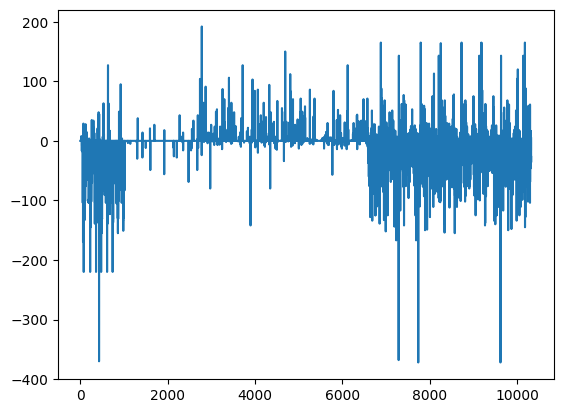

In [356]:
# Checking out the delay column..
delay=pd.to_numeric(ddate['delivery_delay_time'])/(1e9*3600*24)
delay.plot()

In [357]:
#### Engineer the categorical targets:
dobject['delayed'] = ddate['delivery_delay_time']>'0 days'
print("----\nNew delayed column: ", dobject.delayed.value_counts())
print("----\nAverage % of delayed deliveries: ",dobject.delayed.sum()/len(dobject))

----
New delayed column:  delayed
False    9138
True     1186
Name: count, dtype: int64
----
Average % of delayed deliveries:  0.11487795428128632


#### Time Series Features
#### *Lagging, rolling statistics, and cumulative*
#### Cumulative statistics, vendor-item level

In [358]:
#- lag variable: last delivery outcome, last delivery days delay
# merge ddate with delayed and delivery_delay_time
# country-item, vendor-item, factory-item
df_trend = pd.concat([ddate[['del_date_client','delivery_delay_time']]
                      , dobject[['itm_desc','vendor', 'factory', 'delayed']]], axis=1)

df_trend['delayed'] = df_trend.delayed.map({True:1, False:0})
df_trend['delivery_delay_time'] = df_trend.delivery_delay_time.dt.days
# Group and sort to get order
dgrp = df_trend.sort_values(by=['del_date_client', 'vendor', 'itm_desc']
        , ascending =True)[['del_date_client', 'vendor'
                            , 'itm_desc', 'delayed', 'delivery_delay_time']].groupby(
    ['del_date_client', 'vendor', 'itm_desc'])
#df_trend, make sure to shift to avoid collinearity!
dcum = dgrp.agg(['cumsum', 'cummin']).shift(+1)
dcum.columns = ['delay_cumsum', 'delay_cummin', 'del_del_time_cumsum', 'days_delay_cummin']
dcum.head()

,delay_cumsum,delay_cummin,del_del_time_cumsum,days_delay_cummin
522,NaN,NaN,NaN,NaN
412,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0
2480,0.0,0.0,0.0,0.0


In [359]:
# Sort the DataFrame as per the specified columns
dsorted = df_trend.sort_values(by=['del_date_client', 'vendor', 'itm_desc'])

# Calculate rolling means with a window of 21, using the newer .rolling() method.
# The shift(+1) is applied to avoid including the current row in the rolling mean calculation to prevent multicollinearity.
dsorted['delay_rmean'] = dsorted['delayed'].rolling(window=21).mean().shift(+1)
dsorted['days_delay_rmean'] = dsorted['delivery_delay_time'].rolling(window=21).mean()

# Merge the DataFrames together. Assuming 'dcum' is correctly indexed for the merge operation.
# If dcum's index does not align with dsorted's, you may need to adjust this step.
dtrend = pd.merge(dsorted, dcum, how='inner', left_index=True, right_index=True)

# Drop specified columns and sort the index for future operations.
dtrend = dtrend.drop(['del_date_client', 'delivery_delay_time', 'itm_desc', 'vendor', 'factory', 'delayed'], axis=1).sort_index()

# Display the first few rows of the resulting DataFrame.
dtrend.head()

,delay_rmean,days_delay_rmean,delay_cumsum,delay_cummin,del_del_time_cumsum,days_delay_cummin
0,NaN,NaN,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,0.0,0.0,0.0,0.0
3,NaN,NaN,0.0,0.0,0.0,0.0
4,NaN,NaN,0.0,0.0,0.0,0.0


In [360]:
dtrend.fillna(method='bfill', axis=0, inplace=True)
dtrend.isnull().sum()

delay_rmean            0
days_delay_rmean       0
delay_cumsum           0
delay_cummin           0
del_del_time_cumsum    0
days_delay_cummin      0
dtype: int64

In [361]:
### Feature Creation
### External features from other sources

In [362]:
fragility_index = scmhelper.generate_country_stability_features() #fsi index
print(fragility_index.shape)
fragility_index.head()

(2099, 3)


,fsi,year,country
0,112.3,2006,Sudan
1,110.1,2006,Congo Democratic Republic
2,109.2,2006,Cote d'Ivoire
3,109.0,2006,Iraq
4,108.9,2006,Zimbabwe


#### *Logistics Performance Indices (LPI)*

In [363]:
logistics_indices = scmhelper.generate_country_logistics_features() #lpi

189
shape ct:  (189, 36)
missing_cols: 42
(2079, 9)
score_type      country  year   customs     infra  intl_ship  logistic_qlty  \
0           Afghanistan  2006  1.300000  1.100000   1.222220       1.250000   
1           Afghanistan  2007  1.300000  1.100000   1.222220       1.250000   
2           Afghanistan  2008  1.607695  1.357865   1.563119       1.530150   
3           Afghanistan  2009  1.915390  1.615731   1.904017       1.810299   
4           Afghanistan  2010  2.223085  1.873596   2.244916       2.090449   

score_type       lpi  timeliness  track_trace  
0           1.211669    1.375000     1.000000  
1           1.211669    1.375000     1.000000  
2           1.555500    1.785168     1.455168  
3           1.899330    2.195335     1.910335  
4           2.243160    2.605503     2.365503  
lpi describe:  score_type      customs        infra    intl_ship  logistic_qlty          lpi  \
count       2079.000000  2079.000000  2079.000000    2079.000000  2079.000000   
mean    

In [364]:
lpi_fsi_comparison = scmhelper.compare_columns(logistics_indices
                    , fragility_index,'country','country') # compare country colums

data1 shape: 189 data2 shape: 178
(210, 2)
21 32
In data2 but not in data1: ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Cape Verde', 'Congo Democratic Republic', 'Congo Republic', "Cote d'Ivoire", 'Grenada', 'Guinea Bissau', 'Israel and West Bank', 'Laos', 'Micronesia', 'North Korea', 'Russia', 'Samoa', 'Sao Tome and Principe', 'Seychelles', 'South Sudan', 'Suriname', 'Swaziland'] 
----
In data1 but not in data2: ['Bahamas, The', 'Buthan', 'Congo, Dem, Rep,', 'Congo, Dem. Rep.', 'Congo, Rep,', 'Congo, Rep.', "Côte d'Ivoire", 'Egypt, Arab Rep,', 'Egypt, Arab Rep.', 'Gambia, The', 'Guinea-Bissau', 'Hong Kong SAR, China', 'Hong Kong, China', 'Iran, Islamic Rep,', 'Iran, Islamic Rep.', 'Israel', 'Korea, Rep,', 'Korea, Rep.', 'Lao PDR', 'Laos, PDR', 'Luxemburg', 'Macedonia, FYR', 'Russian Federation', 'Sao Tome', 'Sco Tomi and Principe', 'SerbiaMontenegro', 'Syrian Arab Republic', 'São Tomé and Principe', 'Taiwan', 'Taiwan, China', 'Venezuela, RB', 'Yemen, Rep.']


In [365]:
lpi_fsi_combined = scmhelper.combine_logistics_and_stability_features(
    logistics_indices, fragility_index) # combine logistics (lpi) and fragility (fsi) indices


Country names to harmonize:  ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas, The' 'Bahrain' 'Bangladesh'
 'Belarus' 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Buthan' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo, Dem, Rep,' 'Congo, Dem. Rep.' 'Congo, Rep,' 'Congo, Rep.'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' "Côte d'Ivoire"
 'Denmark' 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt'
 'Egypt, Arab Rep,' 'Egypt, Arab Rep.' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia'
 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Guinea'
 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras' 'Hong Kong SAR, China'
 'Hong Kong, China' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran'
 'Iran, Is

#### *Factory Location, Country and Continent*

In [366]:
# Generate Factory Metrics. Rerun if you get Index Error, Google's Fault
#factory_metrics = scmhelper.generate_factory_location_features(dobject)

# Alternatively, if generate facotry location is too slow or break
# then use already generated tables from this file below...
factory_metrics = pd.read_csv('data/features/factory_map_premade.csv', encoding = "ISO-8859-1")

In [367]:
# Join them to main data (Next Step Depends on this!)
dobject = scmhelper.add_factory_origin_features(dobject, factory_metrics)

In [368]:
destination_metrics, origin_metrics = scmhelper.destination_and_origin_lpi_fsi_indicators(
    dobject, lpi_fsi_combined)

Destination countries data:  (430, 5) Unique countries:  ['Afghanistan' 'Angola' 'Belize' 'Benin' 'Botswana' 'Burkina Faso'
 'Burundi' 'Cameroon' 'Congo, DRC' "Côte d'Ivoire" 'Dominican Republic'
 'Ethiopia' 'Ghana' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Kazakhstan'
 'Kenya' 'Kyrgyzstan' 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Malawi'
 'Mali' 'Mozambique' 'Namibia' 'Nigeria' 'Pakistan' 'Rwanda' 'Senegal'
 'Sierra Leone' 'South Africa' 'South Sudan' 'Sudan' 'Swaziland'
 'Tanzania' 'Togo' 'Uganda' 'Vietnam' 'Zambia' 'Zimbabwe'] Origin countries data:  (220, 5) Unique countries:  ['Australia' 'Canada' 'China' 'Cyprus' 'France' 'Germany' 'Greece' 'India'
 'Ireland' 'Italy' 'Netherlands' 'Norway' 'Poland' 'Puerto Rico'
 'South Africa' 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'Thailand'
 'United Kingdom' 'United States']
data1 shape: 43 data2 shape: 178
(181, 2)
138 3
In data2 but not in data1: ['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', '

### Save the blocks of data separately in *"Data/Features"* folder
#### *To be uploaded in next NoteBook - EDA and Feature Selection*

In [370]:
# Fill the nulls
nullc = dobject.isnull().sum()[dobject.isnull().sum()>0].index.tolist()
for c in nullc:
    try:
        cmean = dobject[c].mean(numeric_only=True)
        dobject[c].fillna(cmean, inplace=True)
    except:
        print('error')

# Split the numerical columns from dobject to separate df
dobject['delayed'] = pd.Categorical(dobject.delayed)
#mainblocks = scmhelper.get_blocks_by_dtype(dobject)
#mainblocks.keys()
#print("mainblock" ,mainblocks)
# Convert to categorical
non_numerical_df = dobject.select_dtypes(exclude='number')
#print(mainblocks.keys())
for c in non_numerical_df.columns:
    print('*******',c)
    if c == 'factory':
        continue
    #print(c)
    non_numerical_df[c] = pd.Categorical(non_numerical_df[c])
    #mainblocks['object'][c] = pd.Categorical(mainblocks['object'][c])
# Do the do_purch, do_del split here as well
#mainblocks.keys()
print("Numerical columns:", non_numerical_df.columns.tolist())

******* proj_code
******* pq_no
******* po_no
******* ship_no
******* country
******* mngr
******* fulfill_via
******* vendor_terms
******* ship_mode
******* pq_date
******* po_date
******* prod_grp
******* sub_class
******* vendor
******* itm_desc
******* molecule_test
******* brand
******* dosage
******* dosage_form
******* factory
******* first_line
******* weight
******* freight_cost
******* pq_date_new_yr
******* pq_date_new_mn
******* pq_date_new_dy
******* po_date_new_yr
******* po_date_new_mn
******* po_date_new_dy
******* del_date_scheduled_yr
******* del_date_scheduled_mn
******* del_date_scheduled_dy
******* del_date_client_yr
******* del_date_client_mn
******* del_date_client_dy
******* del_date_recorded_yr
******* del_date_recorded_mn
******* del_date_recorded_dy
******* pq_date_new_wd
******* pq_date_new_wk
******* pq_date_new_qt
******* po_date_new_wd
******* po_date_new_wk
******* po_date_new_qt
******* del_date_scheduled_wd
******* del_date_scheduled_wk
******* del_dat

In [371]:
dnum_country.head()

,country,factory,vendor,molecule_test,brand,del_date_scheduled_yr,country_qtysum,country_qtycount,country_qtymean,country_valsum,...,country_valmean,country_inssum,country_inscount,country_insmean,country_weightsum,country_weightcount,country_weightmean,country_costsum,country_costcount,country_costmean
0,Côte d'Ivoire,Ranbaxy Fine Chemicals LTD,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,2006,29553,14,2110.928571,370713.70,...,26479.55,0.0343,14,0.00245,55207.914059,14,3943.422433,9.418457e+05,14,67274.693036
1,Vietnam,"Aurobindo Unit III, India",Aurobindo Pharma Limited,Nevirapine,Generic,2006,152998,12,12749.833333,1358232.36,...,113186.03,0.0294,12,0.00245,13594.489692,12,1132.874141,1.136473e+06,12,94706.044620
2,Côte d'Ivoire,ABBVIE GmbH & Co.KG Wiesbaden,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",Determine,2006,29553,14,2110.928571,370713.70,...,26479.55,0.0343,14,0.00245,55207.914059,14,3943.422433,9.418457e+05,14,67274.693036
3,Vietnam,"Ranbaxy, Paonta Shahib, India",SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,Generic,2006,152998,12,12749.833333,1358232.36,...,113186.03,0.0294,12,0.00245,13594.489692,12,1132.874141,1.136473e+06,12,94706.044620
4,Vietnam,"Aurobindo Unit III, India",Aurobindo Pharma Limited,Stavudine,Generic,2006,152998,12,12749.833333,1358232.36,...,113186.03,0.0294,12,0.00245,13594.489692,12,1132.874141,1.136473e+06,12,94706.044620


In [380]:
entities =['country', 'factory', 'vendor', 'brand', 'molecule_test']
# Drop redundant columns in 
for d in [dnum_country, dnum_factory, dnum_vendor, dnum_brand, dnum_molecule_test]:
    try:
        d.drop(entities, axis=1, inplace=True)
    except:
        pass
# Make columns index
c=['country_qtycount']+[c for c in dnum_country.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
v=['vendor_qtycount']+[c for c in dnum_vendor.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
f=['factory_qtycount']+[c for c in dnum_factory.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
b=['brand_qtycount']+[c for c in dnum_brand.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
m=['molecule_test_qtycount']+[c for c in dnum_molecule_test.columns if 
                                ('sum' in c) or ('mean' in c) or ('yr' in c)]
# Drop duplicate columns for count
dnum_country, dnum_vendor, dnum_factory,dnum_brand, dnum_molecule_test = dnum_country[c],dnum_vendor[v], dnum_factory[f],dnum_brand[b],dnum_molecule_test[m]

['country_qtycount', 'del_date_scheduled_yr', 'country_qtysum', 'country_qtymean', 'country_valsum', 'country_valmean', 'country_inssum', 'country_insmean', 'country_weightsum', 'country_weightmean', 'country_costsum', 'country_costmean']
['vendor_qtycount', 'del_date_scheduled_yr', 'vendor_qtysum', 'vendor_qtymean', 'vendor_valsum', 'vendor_valmean', 'vendor_inssum', 'vendor_insmean', 'vendor_weightsum', 'vendor_weightmean', 'vendor_costsum', 'vendor_costmean']
['brand_qtycount', 'del_date_scheduled_yr', 'brand_qtysum', 'brand_qtymean', 'brand_valsum', 'brand_valmean', 'brand_inssum', 'brand_insmean', 'brand_weightsum', 'brand_weightmean', 'brand_costsum', 'brand_costmean']
['molecule_test_qtycount', 'del_date_scheduled_yr', 'molecule_test_qtysum', 'molecule_test_qtymean', 'molecule_test_valsum', 'molecule_test_valmean', 'molecule_test_inssum', 'molecule_test_insmean', 'molecule_test_weightsum', 'molecule_test_weightmean', 'molecule_test_costsum', 'molecule_test_costmean']


In [386]:
# Merge the categorical elements

dobject  = dobject.select_dtypes(exclude='number')#pd.concat([mainblocks['category'],mainblocks['object']], axis=1)
# Merge the new numerical festures
dnum_lpifsi = dobject.select_dtypes(include='number')#pd.concat([mainblocks['float64'], mainblocks['int64']],axis=1)
# Make lists for the save loop
dchunks = [dnum,dnum_country, dnum_vendor,dnum_factory, dnum_brand
           ,dnum_molecule_test,dnum_lpifsi,ddate, dobject, dtrend]
dnames = ['dnum','dnum_country', 'dnum_vendor', 'dnum_factory', 'dnum_brand'
          , 'dnum_molecule_test','dnum_lpifsi', 'ddate', 'dobject', 'dtrend']
import datetime as dt
import os
for i in range(len(dnames)):
    fn= "_"+str(i)+"_"+dnames[i]+".csv"
    path= os.curdir+'\Data\Features\\'
    print(fn)
    dchunks[i].to_csv(path+fn)

_0_dnum.csv
_1_dnum_country.csv
_2_dnum_vendor.csv
_3_dnum_factory.csv
_4_dnum_brand.csv
_5_dnum_molecule_test.csv
_6_dnum_lpifsi.csv
_7_ddate.csv
_8_dobject.csv
_9_dtrend.csv
